In [2]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [7]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from anndata import AnnData

In [3]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [4]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

### Plotting parameters

In [30]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Analysis

In [14]:
reads_path  = "/home/arion/davidm/Data/datasets/raw/public/RNA-seq/sc/10x-Dropseq-reps_GSE111912/dropseq_rep2/GSM3044889_GeneExp.ReadCounts.DropSeq2.txt.gz"
r = pd.read_table(reads_path, compression="gzip", index_col=0).T
# X = x.values
# obs = {"barcodes" : x.index}
# var = {"external_gene_name" : x.columns}
# sc = AnnData(X = X, obs = obs, var = var)
# rnaseq.setup.setup_anndata(sc, layer="raw", cdna = "3' tag")

In [22]:
umis_path  = "/home/arion/davidm/Data/datasets/raw/public/RNA-seq/sc/10x-Dropseq-reps_GSE111912/dropseq_rep2/GSM3044889_GeneExp.UMIs.DropSeq2.txt"
x = pd.read_table(umis_path, index_col=0).T
X = x.values
obs = {"barcodes" : x.index, "MappedReads" : r.values.sum(1)}
var = {"external_gene_name" : x.columns}
sc = AnnData(X = X, obs = obs, var = var)
rnaseq.setup.setup_anndata(sc, layer="raw", cdna = "3' tag")

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [24]:
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
sc._inplace_subset_obs(~(sc.obs["total_UMIs"] == 0))

rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

sc.obs["DedupRate"] = 1 - (sc.obs["total_UMIs"] / sc.obs["MappedReads"])

total_UMIs already annotated. Set ow = True if you want to overwrite.
Annotating #_genes...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating rp_frac...
external_gene_name already annotated. Set ow = True if you want to overwrite.


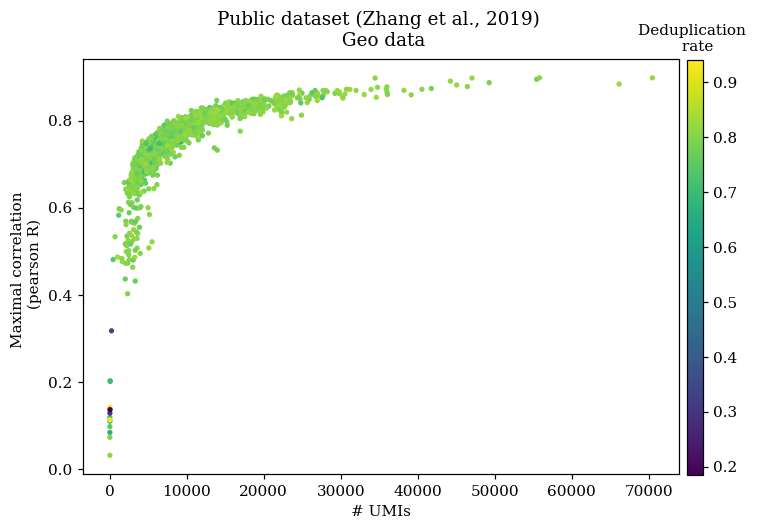

In [31]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "Public dataset (Zhang et al., 2019) \n Geo data",\
                        color_title = "Deduplication \n rate", save = f"./figs/public-geo-UMIs-max-corr.svg")

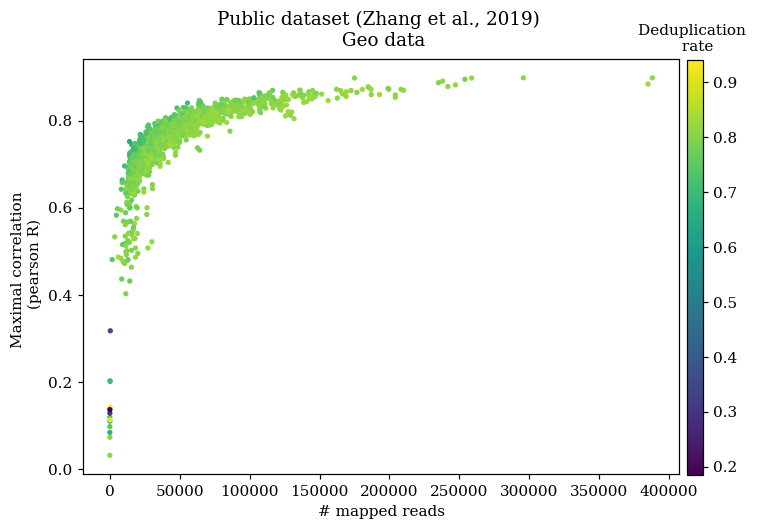

In [32]:
rnaseq.plotting.scatter(sc.obs["MappedReads"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["DedupRate"].values,\
                        xlabel = "# mapped reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "Public dataset (Zhang et al., 2019) \n Geo data",\
                        color_title = "Deduplication \n rate", save = f"./figs/public-geo-reads-max-corr.svg")

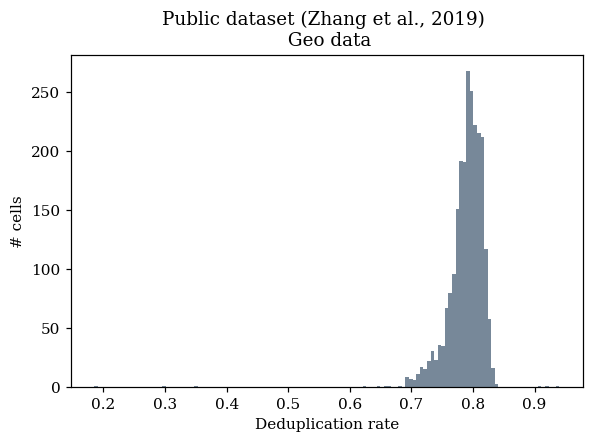

In [33]:
plt.hist(sc.obs["DedupRate"], bins = 130, color = "lightslategray");
plt.xlabel("Deduplication rate");
plt.ylabel("# cells");
plt.title("Public dataset (Zhang et al., 2019) \n Geo data")
plt.savefig(f"./figs/distrib_dedup_public-geo.svg")

In [34]:
%%bash
tar czf ./figs.tar.gz ./figs/*.svg